Here the aim is to see if there is a bias for deep or superficial cells to form firing fields around reward locations

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from nelpy.analysis import replay
from matplotlib.ticker import AutoMinorLocator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [174]:
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell\Z__Data_GrosmarkAD_Achilles_Achilles_10252013.pkl"

with open(session, "rb") as f:
    result = pickle.load(f)

In [175]:
result.keys()

dict_keys(['df', 'ratemaps', 'occupancies', 'x', 'y', 'ts', 'st'])

In [181]:
result['df']

,UID,environment,name,startTime,stopTime,spatial_infos,pvals,linear_dir,basepath
0,1,linear,MazeEpoch,18079.5,20147.0,0.272797,0.023952,0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
1,3,linear,MazeEpoch,18079.5,20147.0,0.119765,0.003992,0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
2,4,linear,MazeEpoch,18079.5,20147.0,0.795463,0.005988,0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
3,5,linear,MazeEpoch,18079.5,20147.0,1.105387,0.009980,0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
4,7,linear,MazeEpoch,18079.5,20147.0,0.264161,0.001996,0,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
...,...,...,...,...,...,...,...,...,...
475,271,linear,MazeEpoch,18079.5,20147.0,0.496561,0.001996,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
476,272,linear,MazeEpoch,18079.5,20147.0,0.379019,0.001996,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
477,273,linear,MazeEpoch,18079.5,20147.0,0.951902,0.197605,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
478,274,linear,MazeEpoch,18079.5,20147.0,0.948417,0.269461,1,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013


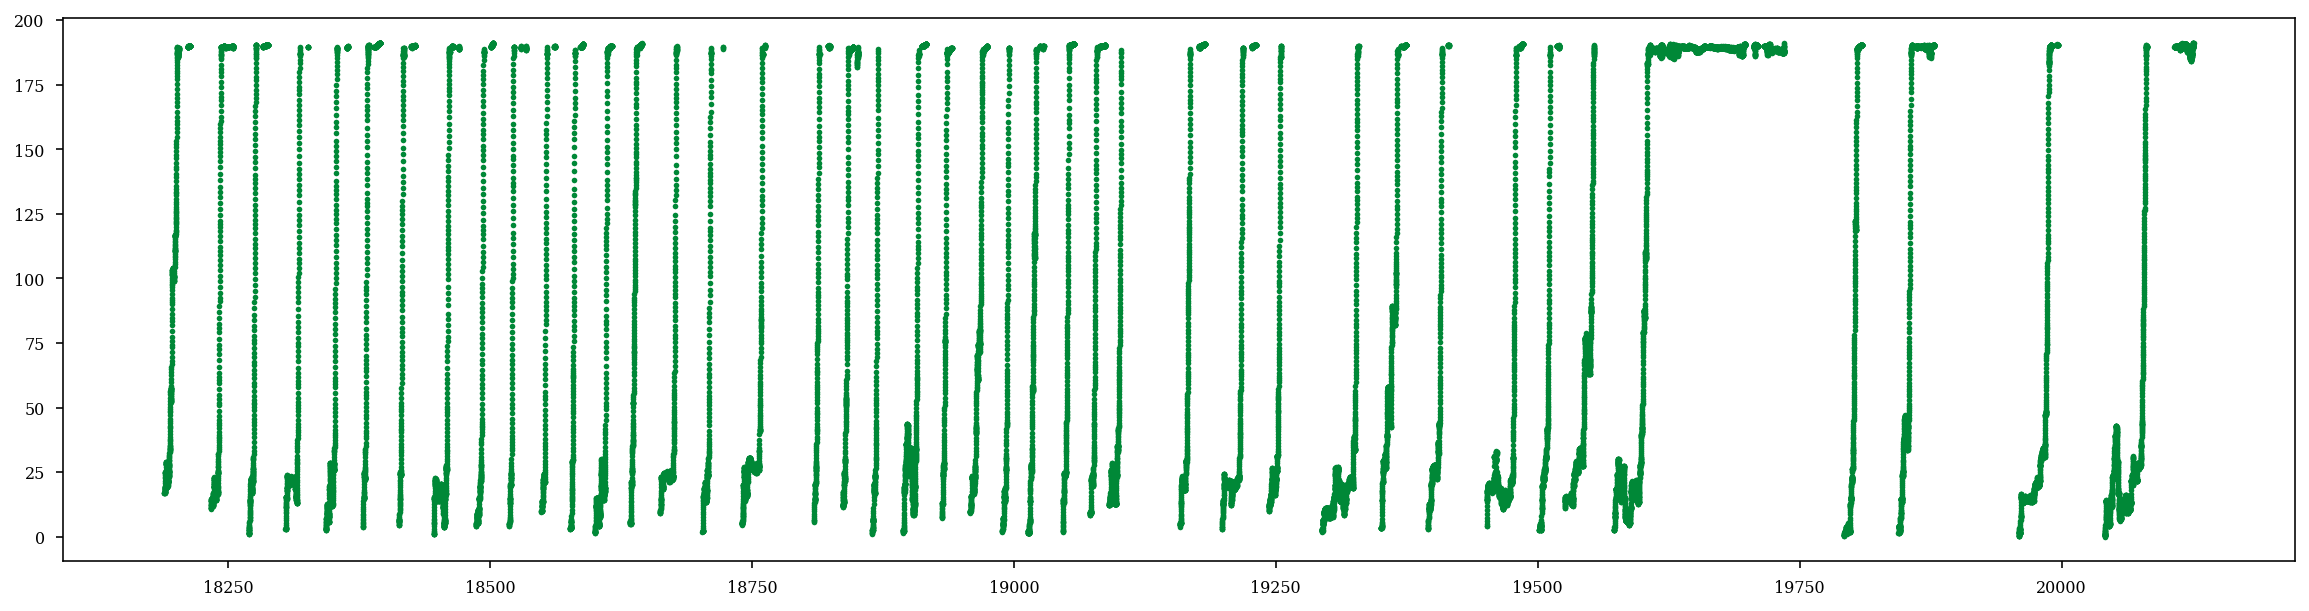

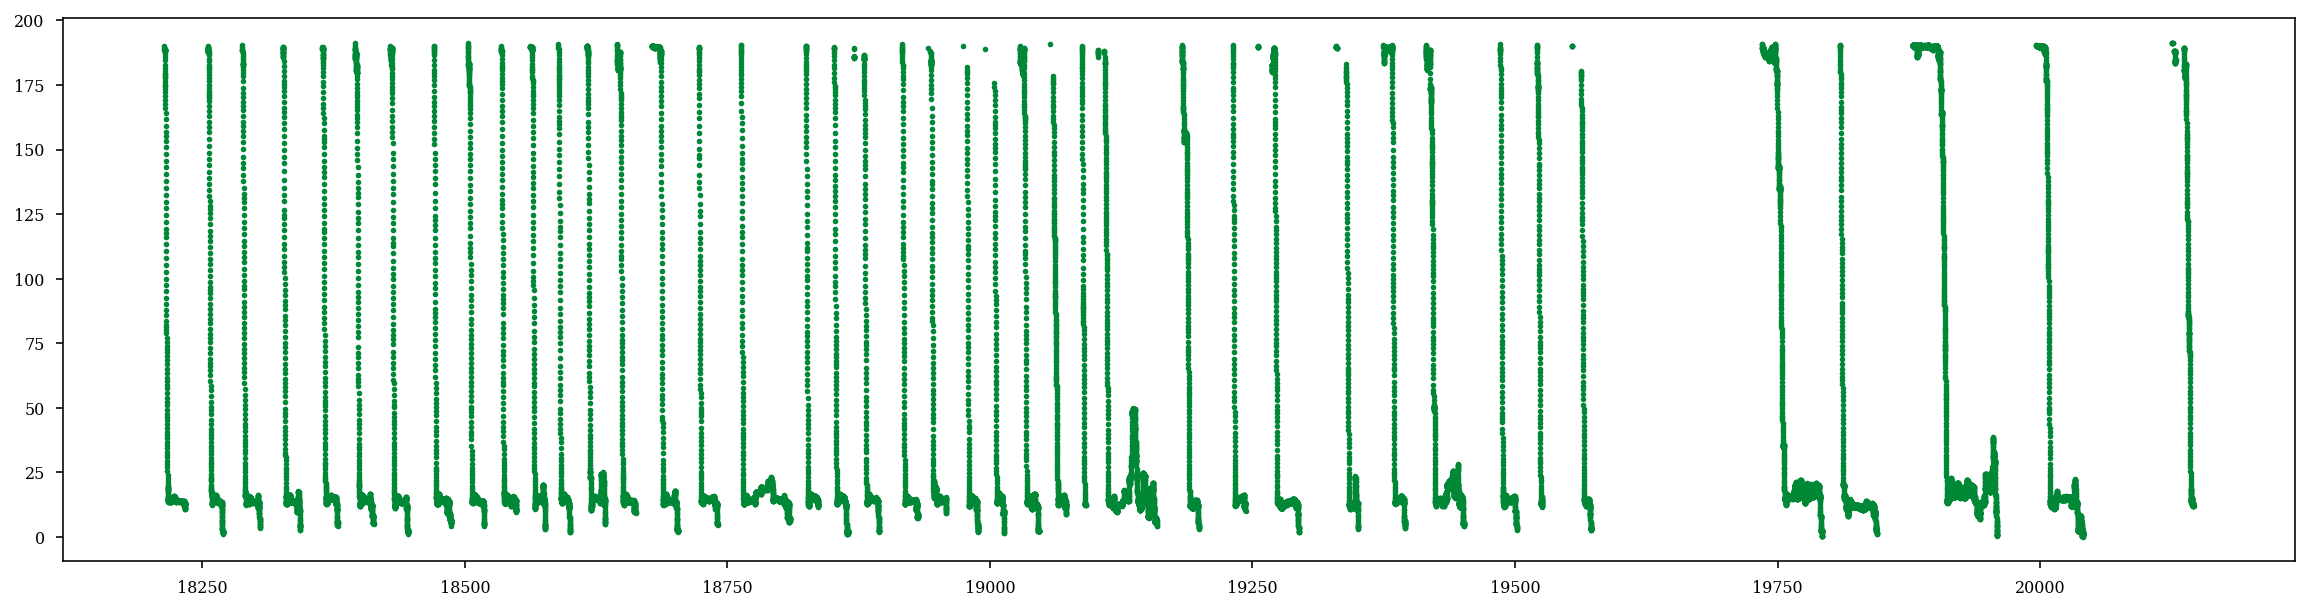

In [186]:
plt.figure(figsize=(20,5))
plt.plot(result['ts'][0], result['x'][0], '.')
plt.figure(figsize=(20,5))
plt.plot(result['ts'][475], result['x'][475], '.')


## pull in place cells results data and compile linear track ratemaps

In [4]:
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell\Z__Data_GrosmarkAD_Achilles_Achilles_10252013.pkl"

# with open(session, "rb") as f:
#     result = pickle.load(f)

In [189]:
def load_in_everything(save_path):
    """
    Load in all the data from a given save_path.
    Input:
        save_path: str, path to the folder containing the data.
    Output:
        result: pandas data frame, containing all the data.
    """

    # locate sessions
    sessions = glob.glob(save_path + os.sep + "*.pkl")

    results = pd.DataFrame()

    # iter over each sessions
    for session in sessions:
        # load in the session data which has: 'df', 'ratemaps', 'occupancies', 'x', 'y', 'ts', 'st'
        with open(session, "rb") as f:
            result = pickle.load(f)
        if result is None:
            continue

        # locate place cells (passed spatial info shuffle) and get their indices
        idx = np.where(
            (result["df"].environment == "linear") & (result["df"].pvals < 0.05)
        )[0]

        # initialize empty vars
        dist_to_end = []
        dist_to_end_norm = []
        peak_rate = []
        dist_to_approach_reward = []
        dist_to_approach_reward_norm = []

        # iter over each place cell
        for i in idx:
            # find and pull out current ratemap
            ratemap = result["ratemaps"][i][0]

            peak_rate.append(ratemap.max())

            # locate the distances of the peak from the start and end of the linear track
            dist_to_start_ = np.abs(np.argmax(ratemap) - 0)
            dist_to_end_ = np.abs(np.argmax(ratemap) - ratemap.shape[0])

            # find minimized distance to either end
            dist_to_end.append(np.min([dist_to_start_, dist_to_end_]))
            # normalize the distance to either end
            dist_to_end_norm.append(dist_to_end[-1] / ratemap.shape[0])

            # based on direction of travel, find the distance to the reward
            if result["df"].iloc[i].linear_dir == 0:
                dist_to_approach_reward.append(dist_to_end_)
            elif result["df"].iloc[i].linear_dir == 1:
                dist_to_approach_reward.append(dist_to_start_)
            else:
                Exception("linear_dir is not 0 or 1")
            # normalize the distance to the reward
            dist_to_approach_reward_norm.append(
                dist_to_approach_reward[-1] / ratemap.shape[0]
            )

        # add the data to the temp results dataframe
        df_temp = result["df"].loc[idx]
        df_temp["peak_rate"] = peak_rate
        df_temp["dist_to_end"] = dist_to_end
        df_temp["dist_to_end_norm"] = dist_to_end_norm
        df_temp["dist_to_approach_reward"] = dist_to_approach_reward
        df_temp["dist_to_approach_reward_norm"] = dist_to_approach_reward_norm

        # add the data to the results dataframe
        results = pd.concat([results, df_temp], ignore_index=True)

    return results


# load data from savepath
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\place_cell"
df = load_in_everything(save_path)
df = add_new_deep_sup.add_new_deep_sup_class(df)


In [190]:
df

,UID,environment,name,startTime,stopTime,spatial_infos,pvals,linear_dir,basepath,peak_rate,dist_to_end,dist_to_end_norm,dist_to_approach_reward,dist_to_approach_reward_norm,deepSuperficialDistance,deepSuperficial
0,1,linear,task,1140.0008,4199.9992,0.329872,0.001996,0.0,Z:\Data\AYAold\AB1\day1,1.402966,14.0,0.358974,25.0,0.641026,-150.000000,Deep
1,9,linear,task,1140.0008,4199.9992,0.690910,0.007984,0.0,Z:\Data\AYAold\AB1\day1,10.491839,3.0,0.076923,3.0,0.076923,0.000000,middle
2,10,linear,task,1140.0008,4199.9992,1.119597,0.005988,0.0,Z:\Data\AYAold\AB1\day1,9.488677,11.0,0.282051,11.0,0.282051,150.000000,Superficial
3,15,linear,task,1140.0008,4199.9992,0.254383,0.005988,0.0,Z:\Data\AYAold\AB1\day1,11.835069,13.0,0.333333,13.0,0.333333,100.000000,Superficial
4,17,linear,task,1140.0008,4199.9992,0.652376,0.001996,0.0,Z:\Data\AYAold\AB1\day1,19.107616,12.0,0.307692,27.0,0.692308,50.000000,Superficial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,77,linear,ec016.269_linear,2472.2000,5842.0000,0.876334,0.001996,1.0,Z:\Data\Kenji\ec016.267_278,9.277443,38.0,0.431818,38.0,0.431818,-44.542208,Deep
6596,78,linear,ec016.269_linear,2472.2000,5842.0000,0.693123,0.003992,1.0,Z:\Data\Kenji\ec016.267_278,18.774009,1.0,0.011364,87.0,0.988636,-44.542208,Deep
6597,79,linear,ec016.269_linear,2472.2000,5842.0000,1.261565,0.003992,1.0,Z:\Data\Kenji\ec016.267_278,2.038246,9.0,0.102273,79.0,0.897727,-64.542208,Deep
6598,80,linear,ec016.269_linear,2472.2000,5842.0000,0.662798,0.001996,1.0,Z:\Data\Kenji\ec016.267_278,3.794975,7.0,0.079545,81.0,0.920455,-84.542208,Deep


Text(0, 0.5, '')

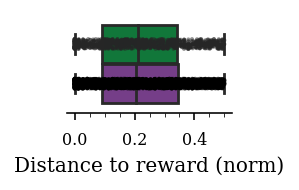

In [192]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.25, subplots=(1, 1)), edgecolor=None
)
group_colors = { "Superficial": "#008837","Deep": "#7b3294",}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(x="dist_to_end_norm",y="environment",hue="deepSuperficial",hue_order=group_colors.keys(),
            data=df[(df.peak_rate>1)],showfliers=False)

sns.stripplot(x="dist_to_end_norm",y="environment",hue="deepSuperficial",hue_order=group_colors.keys(),
            data=df[(df.peak_rate>1)],color="k",s=2,alpha=0.5, dodge=True)
sns.despine()
plt.xlabel("Distance to reward (norm)")

# turn off legend
plt.legend().set_visible(False)
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_yaxis().set_ticks([])
ax.spines["left"].set_visible(False)
ax.set_ylabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "place_cell_dist_to_end_norm.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.savefig(
#     os.path.join(fig_save_path, "place_cell_dist_to_end_norm.jpeg"),
#     dpi=300,
#     bbox_inches="tight",
# )

Text(0, 0.5, '')

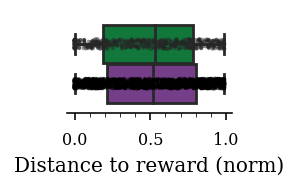

In [195]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.25, subplots=(1, 1)), edgecolor=None
)
group_colors = { "Superficial": "#008837","Deep": "#7b3294",}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(x="dist_to_approach_reward_norm",y="environment",hue="deepSuperficial",hue_order=group_colors.keys(),
            data=df[(df.peak_rate>1) & (df.linear_dir==1)],showfliers=False)

sns.stripplot(x="dist_to_approach_reward_norm",y="environment",hue="deepSuperficial",hue_order=group_colors.keys(),
            data=df[(df.peak_rate>1) & (df.linear_dir==1)],color="k",s=2,alpha=0.5, dodge=True)
sns.despine()
plt.xlabel("Distance to reward (norm)")

# turn off legend
plt.legend().set_visible(False)
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.axes.get_yaxis().set_ticks([])
ax.spines["left"].set_visible(False)
ax.set_ylabel("")


In [213]:
sum(df[(df.peak_rate>1) & (df.deepSuperficial == "Deep")].dist_to_end_norm < .05) / np.sum((df.peak_rate>1) & (df.deepSuperficial == "Deep"))


0.15955473098330242

In [214]:
sum(df[(df.peak_rate>1) & (df.deepSuperficial == "Superficial")].dist_to_end_norm < .05) / np.sum((df.peak_rate>1) & (df.deepSuperficial == "Superficial"))


0.17084942084942084

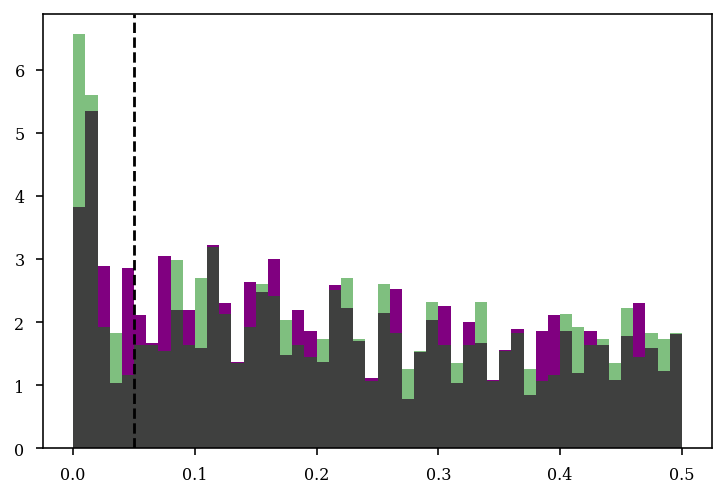

In [204]:
plt.hist(df[(df.peak_rate>1) & (df.deepSuperficial == "Deep")].dist_to_end_norm,50,density=True,color='purple')
plt.hist(df[(df.peak_rate>1) & (df.deepSuperficial == "Superficial")].dist_to_end_norm,50,density=True,alpha=.5,color='g')
plt.axvline(0.05,color='k',linestyle='--')
plt.show()

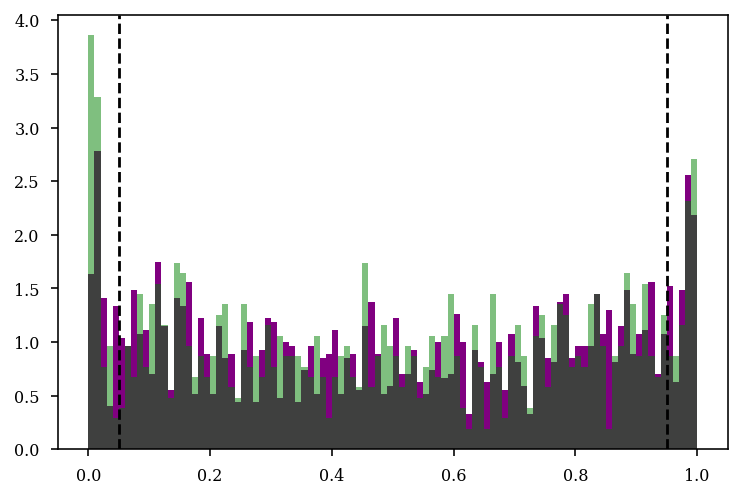

In [199]:
plt.hist(df[(df.peak_rate>1) & (df.deepSuperficial == "Deep")].dist_to_approach_reward_norm,100,density=True,color='purple')
plt.hist(df[(df.peak_rate>1) & (df.deepSuperficial == "Superficial")].dist_to_approach_reward_norm,100,density=True,alpha=.5,color='g')
plt.axvline(0.05,color='k',linestyle='--')
plt.axvline(0.95,color='k',linestyle='--')

plt.show()

In [224]:
prop_outbound_to_reward_sup = sum(
    (df.peak_rate > 1)
    & (df.deepSuperficial == "Superficial")
    & (df.linear_dir == 0)
    & (df.dist_to_approach_reward_norm > 0.95)
) / sum(
    (df.peak_rate > 1) & (df.deepSuperficial == "Superficial") & (df.linear_dir == 0)
)


prop_inbound_to_reward_sup = sum(
    (df.peak_rate > 1)
    & (df.deepSuperficial == "Superficial")
    & (df.linear_dir == 1)
    & (df.dist_to_approach_reward_norm < 0.05)
) / sum(
    (df.peak_rate > 1) & (df.deepSuperficial == "Superficial") & (df.linear_dir == 1)
)

prop_outbound_to_reward_deep = sum(
    (df.peak_rate > 1)
    & (df.deepSuperficial == "Deep")
    & (df.linear_dir == 0)
    & (df.dist_to_approach_reward_norm > 0.95)
) / sum(
    (df.peak_rate > 1) & (df.deepSuperficial == "Deep") & (df.linear_dir == 0)
)

prop_inbound_to_reward_deep = sum(
    (df.peak_rate > 1)
    & (df.deepSuperficial == "Deep")
    & (df.linear_dir == 1)
    & (df.dist_to_approach_reward_norm < 0.05)
) / sum(
    (df.peak_rate > 1) & (df.deepSuperficial == "Deep") & (df.linear_dir == 1)
)

prop_outbound_to_reward_deep, prop_outbound_to_reward_sup, prop_inbound_to_reward_deep, prop_inbound_to_reward_sup

(0.08632040965618142,
 0.07850467289719626,
 0.07078313253012049,
 0.11177644710578842)

In [211]:
prop_to_reward_sup = np.sum(
    (df.peak_rate > 1)
    & (df.deepSuperficial == "Superficial")
    & (
        (df.dist_to_approach_reward_norm > 0.95)
        | (df.dist_to_approach_reward_norm < 0.05)
    )
) / np.sum((df.peak_rate > 1) & (df.deepSuperficial == "Superficial"))

prop_to_reward_deep = np.sum(
    (df.peak_rate > 1)
    & (df.deepSuperficial == "Deep")
    & (
        (df.dist_to_approach_reward_norm > 0.95)
        | (df.dist_to_approach_reward_norm < 0.05)
    )
) / np.sum((df.peak_rate > 1) & (df.deepSuperficial == "Deep"))

prop_to_reward_deep, prop_to_reward_sup


(0.15955473098330242, 0.17084942084942084)

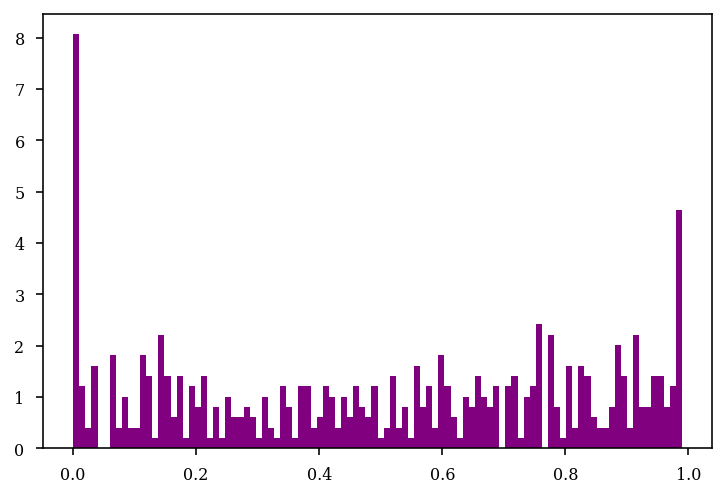

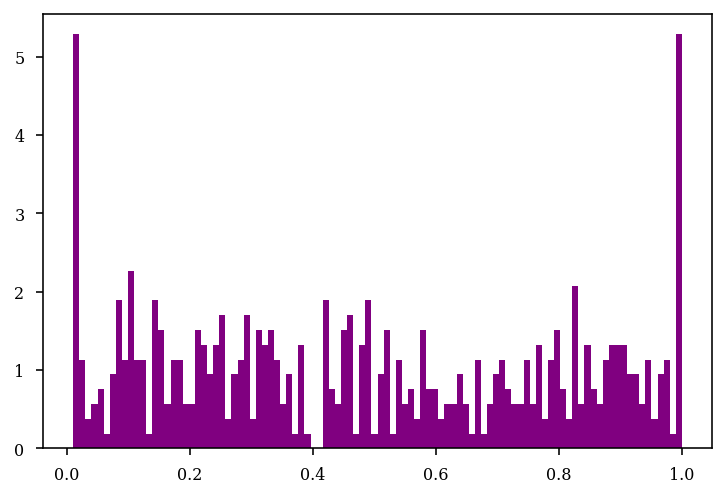

In [205]:
plt.hist(df[(df.peak_rate>1) & (df.deepSuperficial == "Superficial") & (df.linear_dir==1)].dist_to_approach_reward_norm,100,density=True,color='purple')
plt.show()
plt.hist(df[(df.peak_rate>1) & (df.deepSuperficial == "Superficial") & (df.linear_dir==0)].dist_to_approach_reward_norm,100,density=True,color='purple')
plt.show()